In [1]:
#2/7/24 Neural Net for model creation using Combined NR-AR Endocrine Chemopy Data
#Suppress unneeded low level warning messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np
#Data import
#targetdata = pd.read_csv('/Users/james/Documents/Honours/Data/structdata/Mutagen/mutagenMorganfp.csv')

datasets = []
index = []
directory = '/Users/james/Documents/Honours/Data/structdata/endocrine_redux/Chemopy/NR-AR/'
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if 'csv' in filename:
        pathname = directory + file
        df = pd.read_csv(pathname)
        df.drop(columns=['SMILES'], inplace=True)
        
        #drops 90% of negative columns to resolve class imbalance
        ytrain = df.iloc[:, 0].values
        reps = 0
        todrop = []
        for item in ytrain:
            if reps % 10 != 0 and item == 0:
                todrop.append(reps)
            reps = reps + 1

        df = df.drop(todrop)
        df = df.dropna(axis=1)
        datasets.append(df)
        index.append(file)

targetdata = datasets[0]
for item in datasets[1:]:
    targetdata = pd.concat([targetdata, item.iloc[:,2:]], axis=1)
#Creating test/train splits
from sklearn.model_selection import train_test_split
targetdata, validset = train_test_split(targetdata, test_size=0.2, random_state=81)
trainset, testset = train_test_split(targetdata, test_size=0.2, random_state=81)
#Converts Toxicity Values to a list
temp = trainset['Toxicity_Values']
ytrain = []
for items in temp:
    ytrain.append(items)
ytest = testset['Toxicity_Values'].values
#Converts encoded drug target values to an array
xtrain = trainset.iloc[:, 2:].values
xtest = testset.iloc[:, 2:].values

In [2]:
targetdata

,Toxicity_Values,TPSA1,LabuteASA,slogPVSA0,slogPVSA1,slogPVSA2,slogPVSA3,slogPVSA4,slogPVSA5,slogPVSA6,...,CIC3,CIC4,CIC5,CIC6,kappam2,kappam3,phi,kappa1,kappa2,kappa3
5890,0,23.47,144.680324,0.000000,29.137791,18.256634,5.917906,36.958650,48.530937,0.0,...,0.608226,0.460976,0.500192,0.539407,5.928050,2.666892,3.880827,17.415638,6.957500,3.241071
720,0,0.00,46.013992,0.000000,10.716273,0.000000,0.000000,0.000000,0.000000,0.0,...,0.750000,3.000000,3.000000,3.000000,3.075339,4.870000,3.610448,5.000000,2.250000,4.000000
1138,1,6.48,124.950154,4.899910,32.084767,0.000000,0.000000,6.420822,58.321903,0.0,...,0.887744,0.637744,0.587744,0.587744,5.897404,2.866009,3.989380,14.917355,6.840000,3.442500
2980,0,26.30,84.206520,0.000000,12.576187,4.736863,0.000000,24.205463,41.980960,0.0,...,1.009452,0.911063,0.911063,0.911063,5.222555,3.800189,3.920814,12.071429,6.477509,4.888889
6880,0,23.06,89.471692,0.000000,25.286439,0.000000,5.207253,58.290310,0.000000,0.0,...,1.982542,1.734620,1.891436,2.274804,8.246646,13.011575,8.199523,14.000000,8.320000,13.090909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,1,58.89,161.972937,0.000000,22.489294,9.531400,41.430399,71.634869,16.804837,0.0,...,0.909122,0.474306,0.474306,0.474306,6.689207,2.574685,4.607189,20.280000,7.679584,3.056327
6790,0,58.36,54.004297,11.050456,37.110050,0.000000,0.000000,0.000000,0.000000,0.0,...,0.500000,0.500000,0.500000,0.500000,2.681409,1.322174,1.892332,7.111111,3.239669,1.704142
5960,0,26.02,65.452958,5.733667,0.000000,0.000000,0.000000,0.000000,42.464569,0.0,...,0.437744,0.400000,0.437744,0.200000,2.274078,1.049306,1.287051,7.638889,3.164062,1.600000
5130,0,124.32,180.111566,0.000000,121.343692,31.414986,0.000000,27.694949,0.000000,0.0,...,1.845346,2.042529,1.929853,2.014360,17.940535,14.867357,18.134964,29.000000,17.657439,14.604938


In [3]:
#Function dump for metric calculations
#Creation of ROC as a metric
#Function to calculate fpr and tpr of a model given its predictions, the actual values and a threshold
def ratecalc(predictions, threshold, toxtest):
    fpcount = 0
    tpcount = 0
    tncount = 0
    fncount = 0

    loops = 0
    for pred in predictions:
        predtox = pred[0]
        realtox = toxtest[loops]
        if predtox > threshold:
            if realtox != 0:
                tpcount = tpcount + 1
            else:
                fpcount = fpcount + 1
        else:
            if realtox != 0:
                fncount = fncount + 1
            else:
                tncount = tncount + 1

        loops = loops + 1

    fpr = fpcount / (fpcount + tncount)
    tpr = tpcount / (tpcount + fncount)
    
    return(fpr, tpr)

#Function to calculate net accuracy in relation to threshold
import math
def acccalc(predictions, threshold, toxtest):
    correctcount = 0
    fpcount = 0
    tpcount = 0
    tncount = 0
    fncount = 0
    testpos = 0
    testneg = 0

    loops = 0
    for pred in predictions:
        predtox = pred[0]
        realtox = toxtest[loops]
        if predtox > threshold:
            if realtox != 0:
                testpos = testpos + 1
                correctcount = correctcount + 1
                tpcount = tpcount + 1
            else:
                fpcount = fpcount + 1
                testneg = testneg + 1
        else:
            if realtox != 0:
                testpos = testpos + 1
                fncount = fncount + 1
            else:
                testneg = testneg + 1
                correctcount = correctcount + 1
                tncount = tncount + 1

        loops = loops + 1
        
    #netfn = fncount / (fncount + tncount)
    #nettn = tncount / (fncount + tncount)
    netacc = correctcount / (fpcount + fncount + tpcount + tncount)
    #posacc = tpcount / testpos
    #negacc = tncount / testneg
    #netfp = fpcount / (fpcount + tpcount)
    #nettp = tpcount / (tpcount + fpcount)

    fpr = fpcount / (fpcount + tncount)
    tpr = tpcount / (tpcount + fncount)



    f1 = (2 * tpcount) / ((2 * tpcount) + fpcount + fncount)


    tp = tpcount
    fp = fpcount
    tn = tncount
    fn = fncount

    
    temp = math.sqrt((fp + tn) * (tp + fp) * (tp + fn) * (tn + fn))
    if temp == 0:
        return 0
    mcc = ((tp * tn) - (fp * fn)) / temp



    temp = (( ( (tp + fp) * (fp + tn) ) + ( (tp + fn) * (fn + tn) ) ))
    if temp == 0:
        return 0
    kapp =  ( 2 * ((tp * tn) - (fn * fp)) ) / temp
    
    return kapp

In [4]:
#function to calculate various metrics, outputs a list of various metrics with a consistent index
def metriccalc(preds, ytrain):
    correctcount = 0
    fpcount = 0
    tpcount = 0
    tncount = 0
    fncount = 0
    testpos = 0
    testneg = 0
    
    #loop through each item in the predictions, logging positives, negatives and tn/tp/fn/tp
    iterations = 0
    for value in preds:
        testscore = ytrain[iterations]
        if value == 1:
            if testscore != 0:
                testpos = testpos + 1
                correctcount = correctcount + 1
                tpcount = tpcount + 1
            else:
                fpcount = fpcount + 1
                testneg = testneg + 1
        else:
            if testscore != 0:
                testpos = testpos + 1
                fncount = fncount + 1
            else:
                testneg = testneg + 1
                correctcount = correctcount + 1
                tncount = tncount + 1

        iterations = iterations + 1
    
    #calculate a wide swathe of metrics
    netfn = fncount / (fncount + tncount)
    nettn = tncount / (fncount + tncount)
    netacc = correctcount / (fpcount + fncount + tpcount + tncount)
    posacc = tpcount / testpos
    negacc = tncount / testneg
    netfp = fpcount / (fpcount + tpcount)
    nettp = tpcount / (tpcount + fpcount)

    fpr = fpcount / (fpcount + tncount)
    tpr = tpcount / (tpcount + fncount)



    f1 = (2 * tpcount) / ((2 * tpcount) + fpcount + fncount)


    tp = tpcount
    fp = fpcount
    tn = tncount
    fn = fncount

    
    temp = math.sqrt((fp + tn) * (tp + fp) * (tp + fn) * (tn + fn))
    if temp == 0:
        return 0
    mcc = ((tp * tn) - (fp * fn)) / temp



    temp = (( ( (tp + fp) * (fp + tn) ) + ( (tp + fn) * (fn + tn) ) ))
    if temp == 0:
        return 0
    kapp =  ( 2 * ((tp * tn) - (fn * fp)) ) / temp
    
    metriclist = [testpos, testneg, fn, tn, tp, fp, netacc, posacc, negacc, fpr, tpr, f1, mcc, kapp]
    
    return metriclist

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import BatchNormalization

# Determines layer size and input/output
# Here it turns the 334 one hot encoded features to 42
keras.utils.set_random_seed(81)
tf.config.experimental.enable_op_determinism()
length = len(xtrain[0])
temp = length
# Encoder Creation
enc_in = keras.Input(shape=(length, 1))
x = keras.layers.Flatten()(enc_in)

# Additional encoder layers
x = keras.layers.Dense(90, activation="relu")(x)
x = keras.layers.Dense(45, activation="relu")(x)
x = keras.layers.Dense(10, activation="relu")(x)

enc_out = keras.layers.Dense(1, activation="sigmoid")(x)
autoencoder = keras.Model(enc_in, enc_out, name='autoencoder')

# Optimiser
optimise = tf.keras.optimizers.Adam(learning_rate=0.00001)

autoencoder.compile(optimise, loss='binary_crossentropy')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 169, 1)]          0         
                                                                 
 flatten (Flatten)           (None, 169)               0         
                                                                 
 dense (Dense)               (None, 90)                15300     
                                                                 
 dense_1 (Dense)             (None, 45)                4095      
                                                                 
 dense_2 (Dense)             (None, 10)                460       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 19,866
Trainable params: 19,866
Non-train

In [6]:
#Runs and creates the autoencoder and outputs parameters to a specs file
ytrain = np.array(ytrain)
epochs = 500
batchsize = 16
losshistory = []

minloss = 1
bestepoch = 0
for epoch in range(epochs):
    logs = autoencoder.fit(
    xtrain,
    ytrain,
    epochs=1,
    batch_size=batchsize),
    validation_split=0.2,
    
    #autoencoder.save(str(f"models/AE-{epoch+1}.keras"))
    loss = logs[0].history['loss'][0]
    losshistory.append(loss)
    if loss < minloss:
        minloss = loss
        bestepoch = epoch
        
#autoencoder.save(str(f"test/AE-{epoch+1}.keras"))
    

40/40 [==============================] - 0s 662us/step - loss: 0.4100


40/40 [==============================] - 0s 695us/step - loss: 0.2972


40/40 [==============================] - 0s 449us/step - loss: 0.2388


40/40 [==============================] - 0s 426us/step - loss: 0.1953


40/40 [==============================] - 0s 445us/step - loss: 0.1853


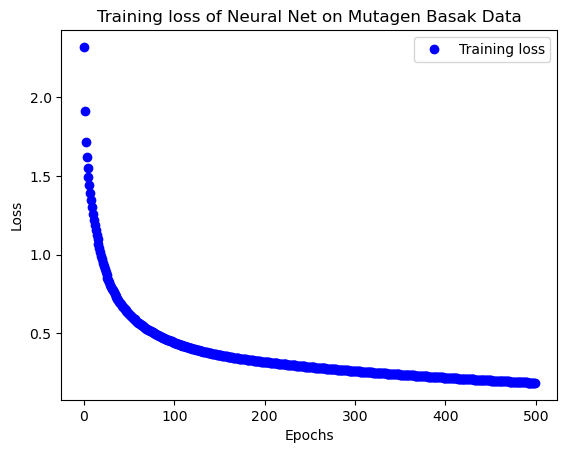

In [7]:
import matplotlib.pyplot as plt
epochcount = range(epochs)
plt.figure()
plt.plot(epochcount, losshistory, 'bo', label='Training loss')
plt.title('Training loss of Neural Net on Mutagen Basak Data')
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


In [8]:
preds = autoencoder.predict(xtest)

5/5 [==============================] - 0s 800us/step


optimal mcc of 0.49247139128689016 at a threshold of 0.68


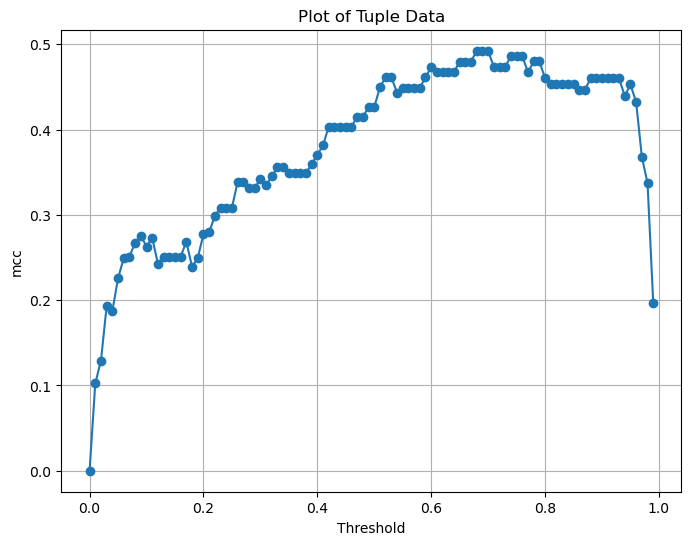

In [9]:
#acc curve creation
acclist = []
thresholdlist = []
maxval = 0
bestthresh = 0
for threshold in np.arange(0, 1, 0.01):
    #newval = acccalc(preds, threshold, ytrain)
    newval = acccalc(preds, threshold, ytest)
    acclist.append(newval)
    thresholdlist.append(threshold)
    if newval > maxval:
        maxval = newval
        bestthresh = threshold

import matplotlib.pyplot as plt
y_values = acclist
x_values = thresholdlist

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, marker='o', linestyle='-')

print('optimal mcc of', maxval, 'at a threshold of', bestthresh)

# Add titles and labels
plt.title('Plot of Tuple Data')
plt.ylabel('mcc')
plt.xlabel('Threshold')

# Display the plot
plt.grid(True)
plt.show()

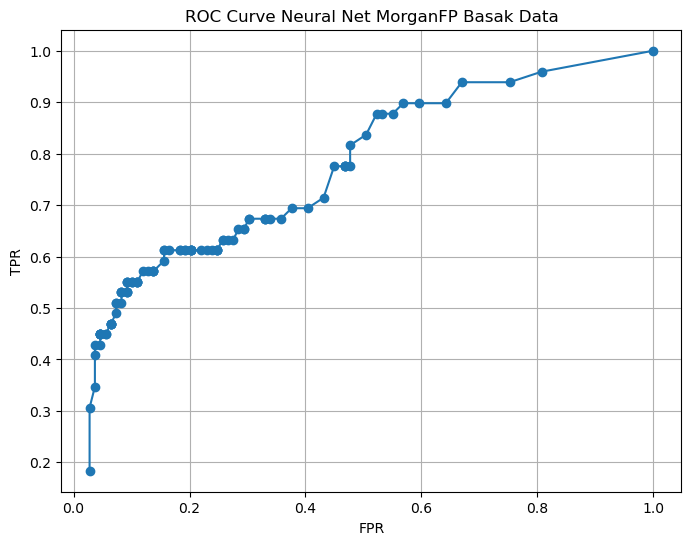

In [10]:
#ROC curve creation
ratelist = []
for threshold in np.arange(0, 1, 0.01):
    ratelist.append(ratecalc(preds, threshold, ytest))

import matplotlib.pyplot as plt
x_values = [x for x, y in ratelist]
y_values = [y for x, y in ratelist]

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, marker='o', linestyle='-')

# Add titles and labels
plt.title('ROC Curve Neural Net MorganFP Basak Data')
plt.xlabel('FPR')
plt.ylabel('TPR')

# Display the plot
plt.grid(True)
plt.show()

In [11]:
correctcount = 0
fpcount = 0
tpcount = 0
tncount = 0
fncount = 0
testpos = 0
testneg = 0

iterations = 0
for value in preds:
    testscore = ytest[iterations]
    #testscore = ytrain[iterations]
    if value > bestthresh:
        if testscore != 0:
            testpos = testpos + 1
            correctcount = correctcount + 1
            tpcount = tpcount + 1
        else:
            fpcount = fpcount + 1
            testneg = testneg + 1
    else:
        if testscore != 0:
            testpos = testpos + 1
            fncount = fncount + 1
        else:
            testneg = testneg + 1
            correctcount = correctcount + 1
            tncount = tncount + 1

    iterations = iterations + 1


print('positives in data', testpos)
print('negatives in data', testneg, '\n')

print('fn count =', fncount)
print('tn count =', tncount)

print('tp count =', tpcount)
print('fp count =', fpcount, '\n')

netfn = fncount / (fncount + tncount)
nettn = tncount / (fncount + tncount)
netacc = correctcount / (fpcount + fncount + tpcount + tncount)
posacc = tpcount / testpos
negacc = tncount / testneg
netfp = fpcount / (fpcount + tpcount)
nettp = tpcount / (tpcount + fpcount)

print('net accuracy =', netacc)
print('positive accuracy =', posacc)
print('negative accuracy =', negacc, '\n')

fpr = fpcount / (fpcount + tncount)
tpr = tpcount / (tpcount + fncount)

print('fpr =', fpr)
print('tpr =', tpr, '\n')

f1 = (2 * tpcount) / ((2 * tpcount) + fpcount + fncount)
print('f1 score =',f1)

tp = tpcount
fp = fpcount
tn = tncount
fn = fncount

mcc = ((tp * tn) - (fp * fn)) / math.sqrt((fp + tn) * (tp + fp) * (tp + fn) * (tn + fn))

print('mcc =',mcc)

temp = (( ( (tp + fp) * (fp + tn) ) + ( (tp + fn) * (fn + tn) ) ))
kapp =  ( 2 * ((tp * tn) - (fn * fp)) ) / temp

print('cohen Kappa =',kapp)

positives in data 49
negatives in data 109 

fn count = 22
tn count = 99
tp count = 27
fp count = 10 

net accuracy = 0.7974683544303798
positive accuracy = 0.5510204081632653
negative accuracy = 0.908256880733945 

fpr = 0.09174311926605505
tpr = 0.5510204081632653 

f1 score = 0.627906976744186
mcc = 0.501640638585322
cohen Kappa = 0.49247139128689016


In [12]:
#Checking if the model is overfit by assessing its values based on its predictions of xtrain

preds = autoencoder.predict(xtrain)
acclist = []
thresholdlist = []
maxval = 0
bestthresh = 0
for threshold in np.arange(0, 1, 0.01):
    newval = acccalc(preds, threshold, ytrain)
    acclist.append(newval)
    thresholdlist.append(threshold)
    if newval > maxval:
        maxval = newval
        bestthresh = threshold

correctcount = 0
fpcount = 0
tpcount = 0
tncount = 0
fncount = 0
testpos = 0
testneg = 0

iterations = 0
for value in preds:
    testscore = ytrain[iterations]
    if value > bestthresh:
        if testscore != 0:
            testpos = testpos + 1
            correctcount = correctcount + 1
            tpcount = tpcount + 1
        else:
            fpcount = fpcount + 1
            testneg = testneg + 1
    else:
        if testscore != 0:
            testpos = testpos + 1
            fncount = fncount + 1
        else:
            testneg = testneg + 1
            correctcount = correctcount + 1
            tncount = tncount + 1

    iterations = iterations + 1


print('positives in data', testpos)
print('negatives in data', testneg, '\n')

print('fn count =', fncount)
print('tn count =', tncount)

print('tp count =', tpcount)
print('fp count =', fpcount, '\n')

netfn = fncount / (fncount + tncount)
nettn = tncount / (fncount + tncount)
netacc = correctcount / (fpcount + fncount + tpcount + tncount)
posacc = tpcount / testpos
negacc = tncount / testneg
netfp = fpcount / (fpcount + tpcount)
nettp = tpcount / (tpcount + fpcount)

print('net accuracy =', netacc)
print('positive accuracy =', posacc)
print('negative accuracy =', negacc, '\n')

fpr = fpcount / (fpcount + tncount)
tpr = tpcount / (tpcount + fncount)

print('fpr =', fpr)
print('tpr =', tpr, '\n')

f1 = (2 * tpcount) / ((2 * tpcount) + fpcount + fncount)
print('f1 score =',f1)

tp = tpcount
fp = fpcount
tn = tncount
fn = fncount

mcc = ((tp * tn) - (fp * fn)) / math.sqrt((fp + tn) * (tp + fp) * (tp + fn) * (tn + fn))

print('mcc =',mcc)

temp = (( ( (tp + fp) * (fp + tn) ) + ( (tp + fn) * (fn + tn) ) ))
kapp =  ( 2 * ((tp * tn) - (fn * fp)) ) / temp

print('cohen Kappa =',kapp)

20/20 [==============================] - 0s 361us/step
positives in data 182
negatives in data 449 

fn count = 27
tn count = 439
tp count = 155
fp count = 10 

net accuracy = 0.9413629160063391
positive accuracy = 0.8516483516483516
negative accuracy = 0.977728285077951 

fpr = 0.022271714922048998
tpr = 0.8516483516483516 

f1 score = 0.8933717579250721
mcc = 0.8550189324657222
cohen Kappa = 0.8530683398679648


In [13]:
min(preds)

array([3.7742668e-28], dtype=float32)